# MNIST Dataset and Regression

## I. Project Description

Computer vision, defined as the process of training computers to interpret and understand digital images, has an increasingly important role in society. Applying computer vision in areas, like healthcare and automation, allows us to extract information and insight from images that would otherwise be difficult for humans to decipher. Datasets, which include digit images, serve as a first steppingstone in exploring computer vision and implementing classification algorithms.

This report will outline the observations, analyses, and results of implementing classification models (logistic regression) to classify the digits in the sklearn load_digits dataset.


## II. Libraries, Data Loading, Previewing Data

#### Libraries

In [31]:
#import libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns 

#### Data Loading

The sklearn digits dataset includes 1797 total 8x8 images of digits, ranging from 0 - 9. 

In [2]:
#loading data from sklearn datasets
mnist = datasets.load_digits()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
#loading mnist data
mnist_data = pd.DataFrame(mnist.data)
mnist_label = pd.DataFrame(mnist.target,columns=['label'])

In [4]:
#display target labels 
mnist_label['label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
#combine into one array for train-test splitting
mnist = pd.concat([mnist_label,mnist_data],axis=1)

#display shape
mnist.shape

(1797, 65)

#### Previewing Data 

In [6]:
#define function for getting digit and reshaping as 28x28
def get_digit(df, digit = None, pos = None):
    if pos != None:
        #throw exception for negative pos
        if pos < 0:
            raise Exception('Position arguement cannot be negative.')
        #filter by digit 
        if digit != None:
            df = df[df['label'] == digit].drop('label',axis=1)
        #throw exception for pos out of bounds 
        if pos > len(df):
            raise Exception('Position out of bounds. Pick a position less than ' + str(len(df)))
        #return reshaped digit for displaying        
        return df.iloc[pos,0:].values.reshape(8,8)
    else:
        #filter by digit
        if digit != None:
            df = df[df['label'] == digit].drop('label',axis=1)
        #return reshaped digit for displaying
        return df.iloc[np.random.randint(0,len(df)),0:].values.reshape(8,8)

In [7]:
#define function to display image
def display(img,ax=None):
    #passing ax object for subplotting if needed 
    if ax!=None:
        ax.imshow(img)
    #else, just display the image
    else:
        plt.imshow(img)
        plt.show()

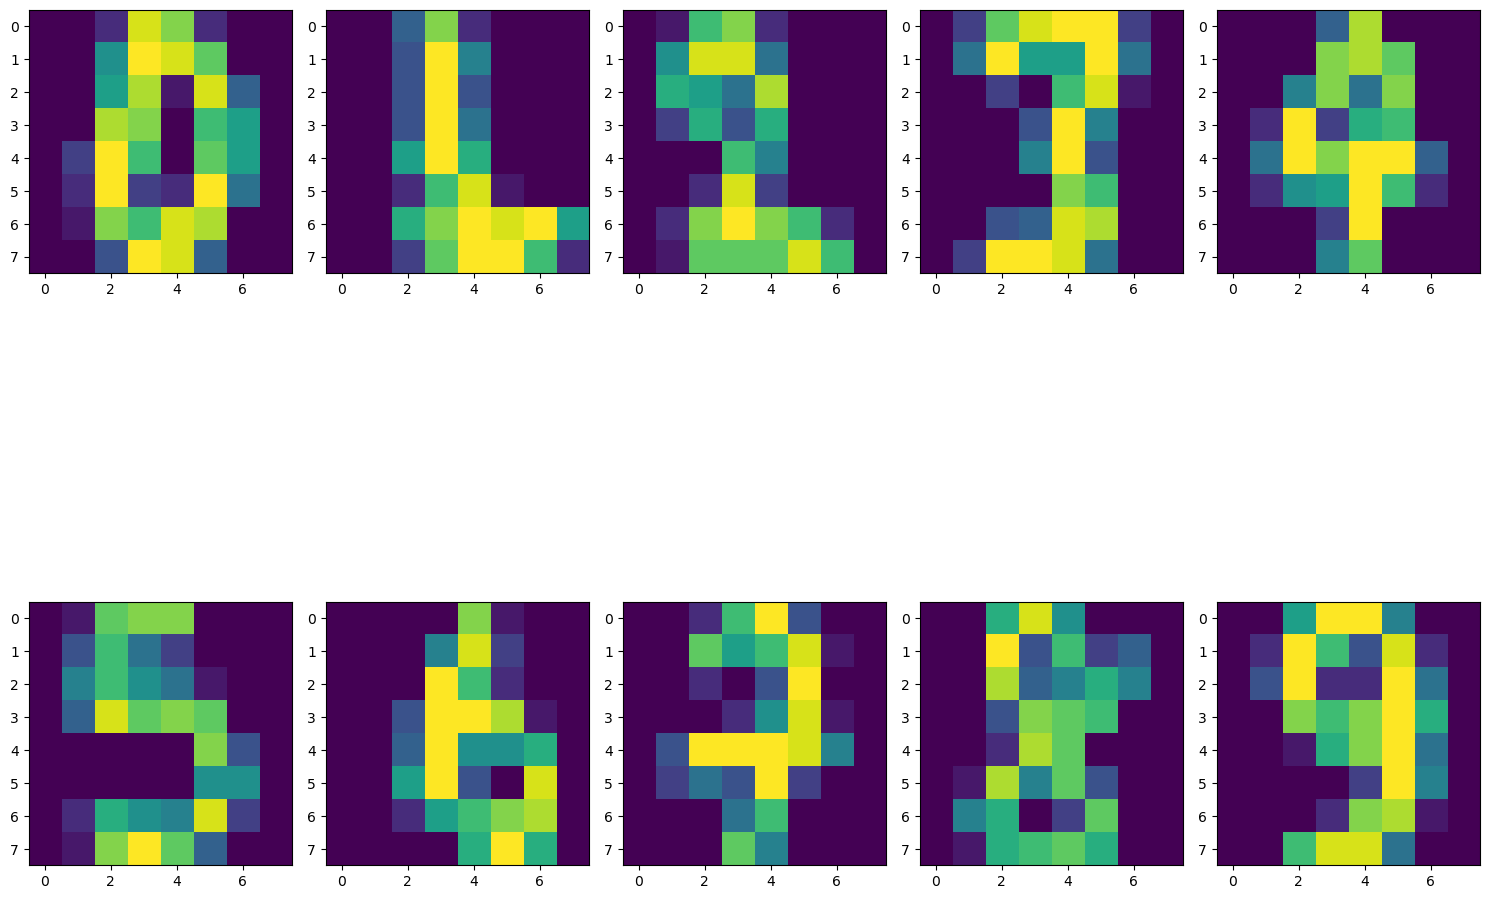

In [8]:
#fig and ax 
fig, ax = plt.subplots(2,5,figsize=(15,15))
ax = ax.ravel()

#display example of each digit 
for digit in range(0,10):
    display(get_digit(mnist, digit),ax[digit])
    
plt.tight_layout()

## III. Data Preprocessing

First, the dataset will be randomized, and then split into training and testing datasets, for model training and evaluating model performance. This step occurs before any additional data preprocessing to avoid affecting the test data. 

Second, features that contain only zeros (do not contain any pixels containing the written digit) will be removed. This step is necessary so that rank-deficiencies and ill-post calculations are not encountered during modelig. 

Third, multicollinearity, when indpendent model features are not actually independent, will be addressed using the Variance Inflation Factor, which measures how well one feature can be predicted by the others. Features with higher than VIF = 5 will be removed, thus reducing any multicollinearity in the system. 

Lastly, the data will be standardized so that features with different scales do not contribute differently to model fitting. This will create a more stable model. 

### Train-Test Split, Feature Reduction, Standard Scaler

#### Train-Test Split

In [9]:
#shuffle rows of mnist dataframe
mnist = mnist.sample(frac = 1)

#define X (explanatory variables) and y (label)
X = mnist.iloc[:,1:]
y = mnist['label']

#train-test splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

#### Feature Reduction

In [10]:
#create mask for columns that sum to 0 and not zero for modeling
mask_zeros = list(X_train.loc[:,(X_train.sum(axis=0) == 0)].columns)
mask_nonzeros = list(X_train.loc[:,(X_train.sum(axis=0) != 0)].columns)

In [11]:
#apply masks
X_train = X_train.iloc[:,mask_nonzeros]
X_test = X_test.iloc[:,mask_nonzeros]

In [12]:
#view dimensions of X_train and X_test
print(X_train.shape)
print(X_test.shape)

(1437, 60)
(360, 60)


#### Variance Inflation Factor

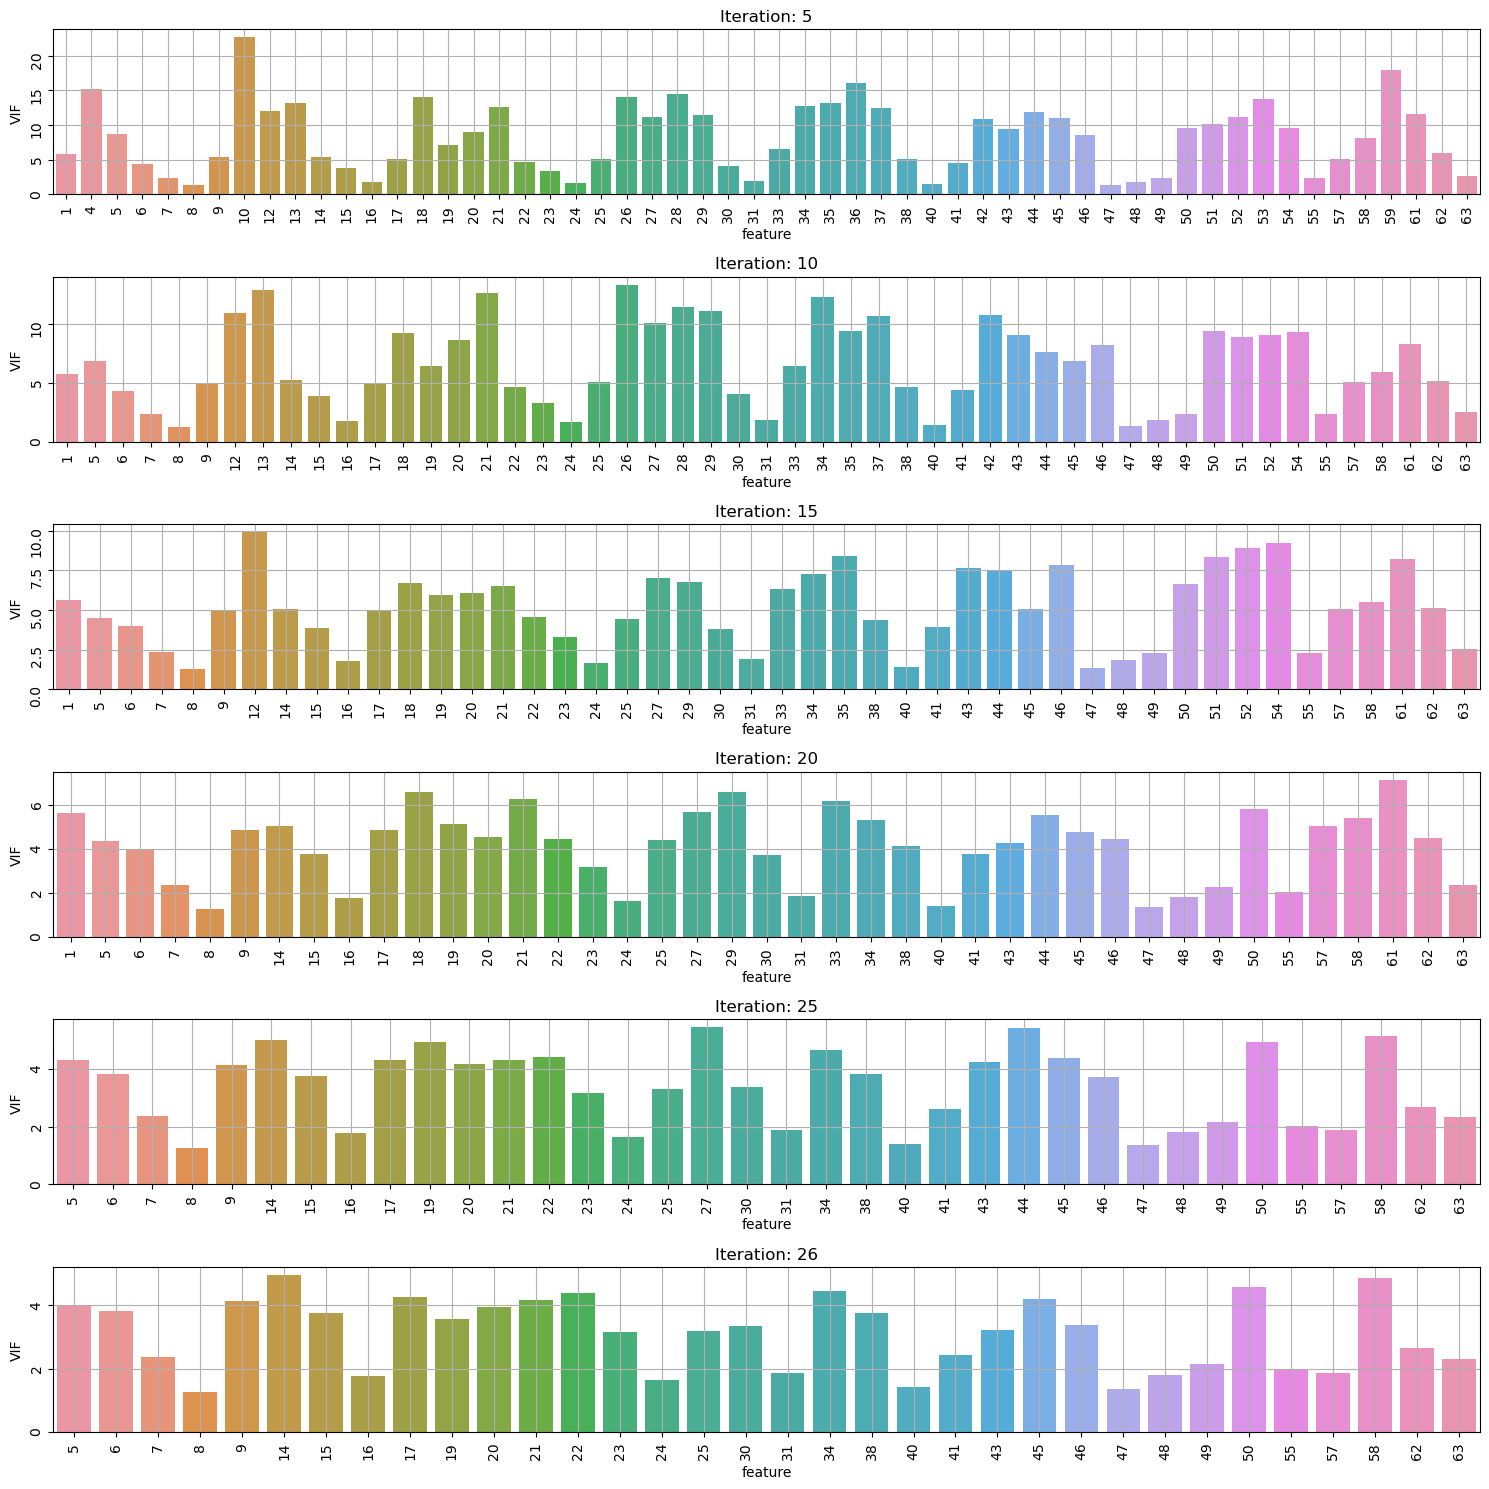

In [13]:
#Define new dataframe for VIF calculations, dropping target variable 
data = X_train

#Define threhold of 5 for VIF, which is the convervative limit for when variables show multicollinearity 
thres = 5

#Counter variables
count = 0
pos = 0

#figures for plotting 
fig, ax = plt.subplots(6,1,figsize=(15,15))
ax = ax.ravel()

#iterative VIF calculations 
while True:
    Cols = range(data.shape[1])
    
    vif = pd.DataFrame([variance_inflation_factor(data.values,i) for i in Cols],columns=['VIF'])
    vif['feature'] = data.columns
    
    if vif['VIF'].max() < thres:
        break
    else:
        Cols = np.delete(Cols, vif['VIF'].idxmax())
        data = data.iloc[:,Cols]
        count+=1
        if count % 5 == 0:
            sns.barplot(data=vif.sort_values('VIF'),x='feature',y='VIF',ax=ax[pos])
            ax[pos].tick_params(labelrotation=90)
            ax[pos].grid()
            ax[pos].set_title('Iteration: %i' % count)
            pos+=1

#plot last iteration 
sns.barplot(data=vif.sort_values('VIF'),x='feature',y='VIF',ax=ax[pos])
ax[pos].tick_params(labelrotation=90)
ax[pos].grid()
ax[pos].set_title('Iteration: %i' % count)
            
plt.tight_layout()

In [14]:
#create mask for features remaining after VIF analysis
mask_reduced = list(data.columns)

In [15]:
#apply masks 
X_train = X_train.loc[:,mask_reduced]
X_test = X_test.loc[:,mask_reduced]

#### Standard Scaler

In [16]:
#standard scaler 
scaler = StandardScaler()

#fit_transform on X_train data
X_train = scaler.fit_transform(X_train)

#transform X_test data 
X_test = scaler.transform(X_test)

## III. Logistic Regression Classifier for digit k vs not k

Logistic regression is a classification technique that outputs the probability of a binary outcome taking place. As a result, we can both classify an input and report on the probability of the outcome occurring. The output of the model will be a number between 0 and 1, where values greater than 0.5 will be classified as 1 or digit k and values less than 0.5 will be classified as 0 or not digit k.

In [17]:
#function to return a deep copy of of y, where k is labeled 1 and not k is labeled 0 
def relabel_y(y, k):
    #find indices of is k and not k 
    isk_idx = y.index[y==k]
    notk_idx = y.index[y!=k]
    #create deep copy of y 
    y_dup = y.copy()
    #label k as 1 and not k as 0
    y_dup.loc[isk_idx] = 1
    y_dup.loc[notk_idx] = 0
    return y_dup 

In [18]:
#function to display logistic model coefficients as an 8x8 image
def modelcoef_as_image(coef,indices):
    #create coeff arr of zeros 
    arr = np.zeros(64)
    #create iterator 
    coef_iterator = iter(coef[0])
    #fill coef list with the defined feature indices 
    for idx in indices:
        arr[idx] = next(coef_iterator)
    plt.imshow(arr.reshape(8,8))
    plt.colorbar()

In [19]:
#function to perform logistic modeling (k vs not k), and return model object
def k_v_notk(X_train, X_test, y_train, k):
    #relabel response variable labels with k as 1 and not k as 0
    y_train_k = relabel_y(y_train,k)
    #modeling
    model = LogisticRegression().fit(X_train, y_train_k)
    y_pred = model.predict(X_test)
    #return model object
    return model

k vs not k Modeling for k = 0 to 9

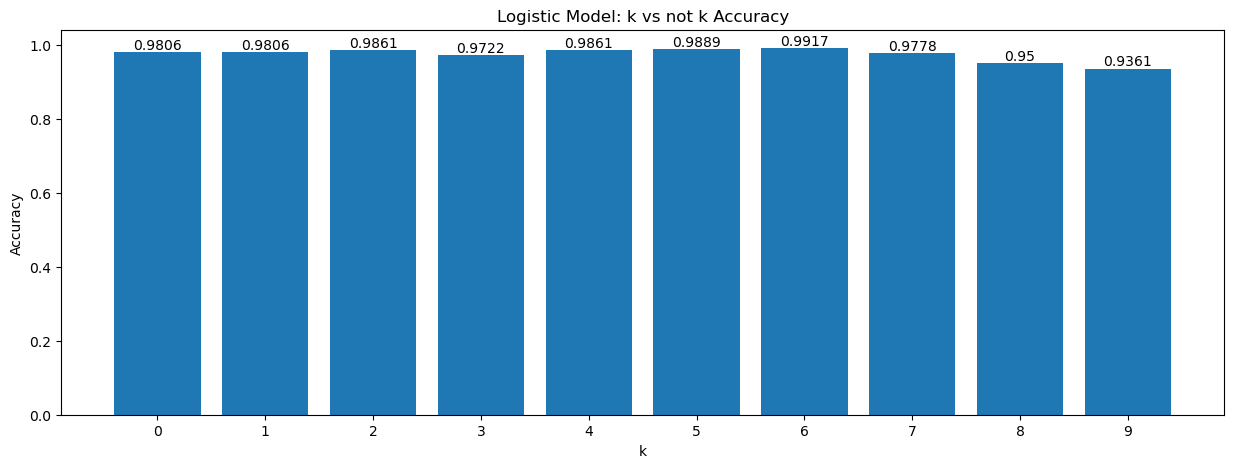

In [69]:
#dict to store accuracy scores of k vs not k logistic models for k = 0 through 9
acc_scores = dict()
#dict for storing models for futher analysis
models = dict()

#loop for modeling 
for k in range(0,10):
    #model k vs not k for specified k 
    model_k = k_v_notk(X_train, X_test, y_train, k)
    #predict using test dataset 
    y_pred_k = model_k.predict(X_test)
    #relabel y_test for k 
    y_test_k = relabel_y(y_test,k)
    #add accuracy scores into dictionary 
    acc_scores[k] = round(accuracy_score(y_test_k,y_pred_k),4)
    #store models into a dictionary for further analysis
    models[k] = [model_k,y_test_k,y_pred_k]
    
#plot accuracy scores
fix, ax = plt.subplots(figsize = (15,5))
bar = ax.bar(acc_scores.keys(),acc_scores.values())
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Logistic Model: k vs not k Accuracy')
plt.xticks(np.arange(0,10));
ax.bar_label(bar);

Best Performing Logistic Model: k = 6

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       316
           1       0.96      0.98      0.97        44

    accuracy                           0.99       360
   macro avg       0.98      0.99      0.98       360
weighted avg       0.99      0.99      0.99       360



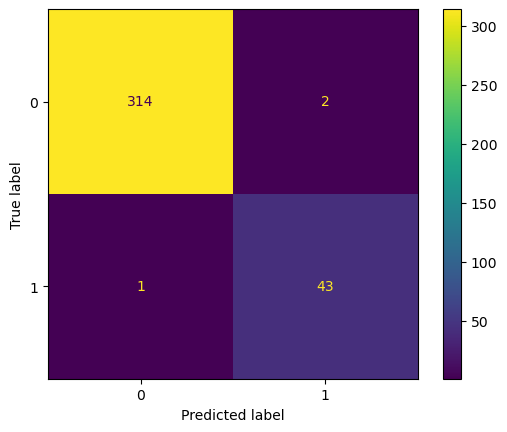

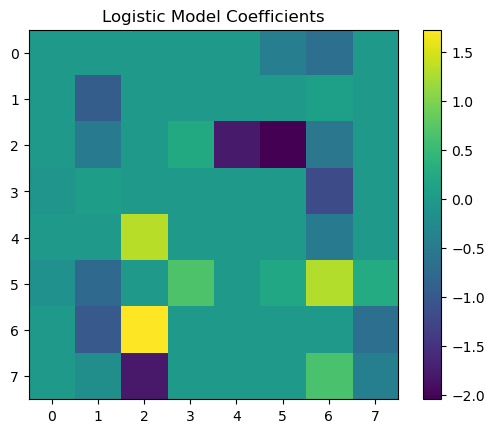

In [87]:
#display classification report, model coefficients, and confusion matrix best performing k vs not k model 
print('Best Performing Logistic Model: k = ' + str(max(acc_scores,key=acc_scores.get))+'\n')
#unpack dictionary for best performing model 
model, y_test_k, y_pred_k = models[max(acc_scores,key=acc_scores.get)]
#classification report 
print(classification_report(y_test_k,y_pred_k))
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test_k,y_pred_k)).plot()
plt.show()
#display model coefficient as 8x8 image
modelcoef_as_image(model.coef_,mask_reduced)
plt.title('Logistic Model Coefficients');

Worst Performing Logistic Model: k = 9

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       318
           1       0.76      0.67      0.71        42

    accuracy                           0.94       360
   macro avg       0.86      0.82      0.84       360
weighted avg       0.93      0.94      0.93       360



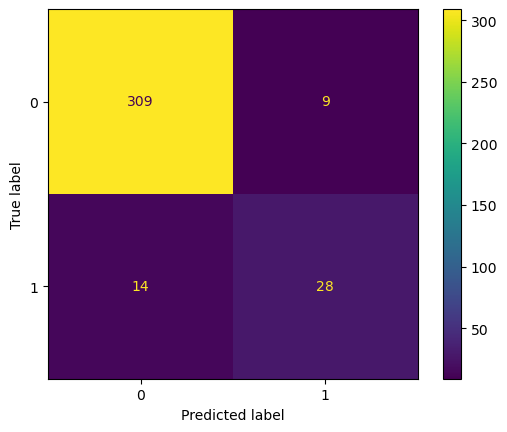

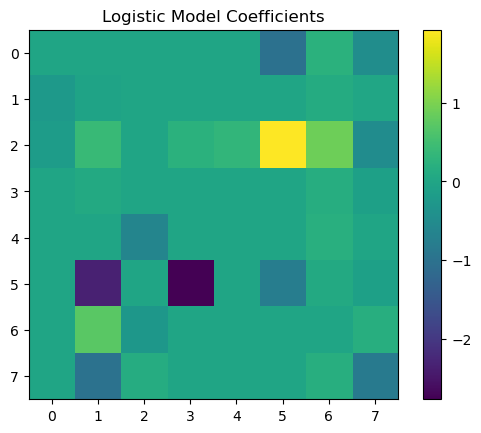

In [88]:
#display classification report, model coefficients, and confusion matrix worst performing k vs not k model 
print('Worst Performing Logistic Model: k = ' + str(min(acc_scores,key=acc_scores.get))+'\n')
#unpack dictionary for best performing model 
model, y_test_k, y_pred_k = models[min(acc_scores,key=acc_scores.get)]
#classification report 
print(classification_report(y_test_k,y_pred_k))
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test_k,y_pred_k)).plot()
plt.show()
#display model coefficient as 8x8 image
modelcoef_as_image(model.coef_,mask_reduced)
plt.title('Logistic Model Coefficients');